In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from gensim.models.keyedvectors import KeyedVectors
import mlflow
import mlflow.pytorch
import os
import matplotlib.pyplot as plt
import json


In [3]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entraînement sur : {device}")

Entraînement sur : cpu


In [4]:
data = pd.read_csv("data/train_df.csv")
data = data.dropna(subset=['words'])
# Validation des données après chargement
print(f'Colonnes disponibles : {data.columns.tolist()}')
print(f'Taille des données avant traitement : {data.shape}')
print(data['target'].value_counts())

Colonnes disponibles : ['target', 'date', 'user', 'text', 'words']
Taille des données avant traitement : (12800, 5)
target
0    6419
1    6381
Name: count, dtype: int64


In [5]:
# Prétraitement : Lemmatisation et Stemming
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text, method="lemmatization"):
    tokens = word_tokenize(text)
    if method == "lemmatization":
        return [lemmatizer.lemmatize(token) for token in tokens]
    elif method == "stemming":
        return [stemmer.stem(token) for token in tokens]


In [6]:
# Appliquer les deux techniques
data["words_lemmatized"] = data["words"].apply(lambda x: " ".join(preprocess_text(x, method="lemmatization")))
data["words_stemmed"] = data["words"].apply(lambda x: " ".join(preprocess_text(x, method="stemming")))

In [7]:
# Division des données
X_lemmatized = data["words_lemmatized"]
X_stemmed = data["words_stemmed"]
y = data["target"]

X_train_lem, X_test_lem, y_train, y_test = train_test_split(X_lemmatized, y, test_size=0.2, random_state=42)
X_train_stem, X_test_stem, _, _ = train_test_split(X_stemmed, y, test_size=0.2, random_state=42)

In [8]:
# Charger des embeddings pré-entraînés (FastText)
def load_fasttext_embeddings(filepath):
    return KeyedVectors.load_word2vec_format(filepath, binary=False)

fasttext_path = "data/wiki-news-300d-1M.vec"
if not os.path.exists(fasttext_path):
    raise FileNotFoundError(f"Le fichier FastText n'a pas été trouvé à l'emplacement : {fasttext_path}")

fasttext_embeddings = load_fasttext_embeddings(fasttext_path)

In [9]:
def build_pretrained_embedding_matrix(vocab, embeddings, embedding_dim):
    matrix = np.zeros((len(vocab) + 1, embedding_dim))
    for word, idx in vocab.items():
        if word in embeddings:
            matrix[idx] = embeddings[word]
    return matrix

In [10]:
# Construire les vocabulaires et matrices d'embedding
embedding_dim = 300
vocab_lem = {word: idx for idx, word in enumerate(set(" ".join(X_train_lem).split()), start=1)}
vocab_stem = {word: idx for idx, word in enumerate(set(" ".join(X_train_stem).split()), start=1)}

embedding_matrix_lem = build_pretrained_embedding_matrix(vocab_lem, fasttext_embeddings, embedding_dim)
embedding_matrix_stem = build_pretrained_embedding_matrix(vocab_stem, fasttext_embeddings, embedding_dim)

In [11]:
# Dataset et DataLoader
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        tokenized = text.split()
        tokenized = tokenized[:self.max_len] + ["<PAD>"] * (self.max_len - len(tokenized))

        return {
            "input_ids": torch.tensor([self.vocab.get(word, 0) for word in tokenized], dtype=torch.long),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [12]:
# Modèle LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.lstm = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=hidden_dim, num_layers=2, dropout=0.6, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Combine directions
        output = self.fc(hidden)
        return output


In [13]:
# Initialisation
hidden_dim = 256
output_dim = 2

model_lem = LSTMClassifier(embedding_matrix_lem, hidden_dim, output_dim).to(device)
model_stem = LSTMClassifier(embedding_matrix_stem, hidden_dim, output_dim).to(device)


In [16]:
# Entraînement avec MLflow
mlflow.set_experiment("lstm_text_classification_experiment")
for name, model, dataset, vocab in zip(
    ["LSTM_Lemmatized", "LSTM_Stemmed"],
    [model_lem, model_stem],
    [X_train_lem, X_train_stem],
    [vocab_lem, vocab_stem]
):
    with mlflow.start_run(run_name=f"{name}-Classification"):
        mlflow.set_tag("model_type", name)

        # Préparer les données
        train_dataset = TextDataset(dataset, y_train, vocab, max_len=50)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        test_dataset = TextDataset(X_test_lem if "Lemmatized" in name else X_test_stem, y_test, vocab, max_len=50)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Entraînement
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        for epoch in range(30):
            model.train()
            epoch_loss = 0

            for batch in train_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["label"].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")
            mlflow.log_metric(f"loss_epoch_{epoch + 1}", epoch_loss)

        # Évaluation sur les données de test
        model.eval()
        y_test_pred = []
        y_test_true = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()

                y_test_pred.extend(preds)
                y_test_true.extend(labels.cpu().numpy())

        # Calcul des métriques pour le test
        test_roc_auc = roc_auc_score(y_test_true, y_test_pred)
        test_accuracy = np.mean(np.array(y_test_true) == np.array(y_test_pred))
        test_precision = np.sum(np.logical_and(np.array(y_test_pred) == 1, np.array(y_test_true) == 1)) / max(np.sum(np.array(y_test_pred) == 1), 1)
        test_recall = np.sum(np.logical_and(np.array(y_test_pred) == 1, np.array(y_test_true) == 1)) / max(np.sum(np.array(y_test_true) == 1), 1)
        test_f1 = 2 * (test_precision * test_recall) / max((test_precision + test_recall), 1e-6)

        # Logging des métriques de test dans MLflow
        mlflow.log_metric("test_roc_auc", test_roc_auc)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1_score", test_f1)

        print(f"Test Results for {name}:")
        print(f"  ROC AUC: {test_roc_auc:.4f}")
        print(f"  Accuracy: {test_accuracy:.4f}")
        print(f"  Precision: {test_precision:.4f}")
        print(f"  Recall: {test_recall:.4f}")
        print(f"  F1 Score: {test_f1:.4f}")
        
        # Sauvegarder le modèle et le vocabulaire
        model_save_path = f"./saved_models/{name}"
        vocab_save_path = f"./saved_vocab/{name}_vocab.json"

        # Créer les dossiers si nécessaire
        os.makedirs(model_save_path, exist_ok=True)
        os.makedirs("./saved_vocab", exist_ok=True)

        # Sauvegarder le modèle
        torch.save(model.state_dict(), os.path.join(model_save_path, "model.pth"))
        mlflow.pytorch.log_model(model, artifact_path=name)

        # Sauvegarder le vocabulaire
        with open(vocab_save_path, 'w') as vocab_file:
            if "Lemmatized" in name:
                json.dump(vocab_lem, vocab_file)
            else:
                json.dump(vocab_stem, vocab_file)

        print(f"Modèle sauvegardé dans : {model_save_path}")
        print(f"Vocabulaire sauvegardé dans : {vocab_save_path}")



Epoch 1, Loss: 114.1279
Epoch 2, Loss: 112.8395
Epoch 3, Loss: 110.5862
Epoch 4, Loss: 106.9900
Epoch 5, Loss: 105.9997
Epoch 6, Loss: 104.9056
Epoch 7, Loss: 101.5879
Epoch 8, Loss: 101.6300
Epoch 9, Loss: 99.6604
Epoch 10, Loss: 97.2721
Epoch 11, Loss: 97.0253
Epoch 12, Loss: 94.3513
Epoch 13, Loss: 91.2275
Epoch 14, Loss: 87.3874
Epoch 15, Loss: 85.5478
Epoch 16, Loss: 85.1479
Epoch 17, Loss: 83.8937
Epoch 18, Loss: 78.7166
Epoch 19, Loss: 79.6445
Epoch 20, Loss: 76.3904
Epoch 21, Loss: 77.6371
Epoch 22, Loss: 90.1596
Epoch 23, Loss: 77.3774
Epoch 24, Loss: 71.3906
Epoch 25, Loss: 70.3074
Epoch 26, Loss: 66.5623
Epoch 27, Loss: 67.8862
Epoch 28, Loss: 61.2133
Epoch 29, Loss: 59.8680
Epoch 30, Loss: 59.9001
Test Results for LSTM_Lemmatized:
  ROC AUC: 0.6788
  Accuracy: 0.6785
  Precision: 0.6958
  Recall: 0.6424
  F1 Score: 0.6680


2025/01/20 19:39:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle sauvegardé dans : ./saved_models/LSTM_Lemmatized
Vocabulaire sauvegardé dans : ./saved_vocab/LSTM_Lemmatized_vocab.json
Epoch 1, Loss: 210.3853
Epoch 2, Loss: 185.6468
Epoch 3, Loss: 177.0503
Epoch 4, Loss: 173.1942
Epoch 5, Loss: 170.2331
Epoch 6, Loss: 169.0845
Epoch 7, Loss: 167.5159
Epoch 8, Loss: 165.2766
Epoch 9, Loss: 164.3336
Epoch 10, Loss: 162.1063
Epoch 11, Loss: 161.2087
Epoch 12, Loss: 159.1719
Epoch 13, Loss: 158.3649
Epoch 14, Loss: 156.7104
Epoch 15, Loss: 155.7366
Epoch 16, Loss: 154.7099
Epoch 17, Loss: 152.6222
Epoch 18, Loss: 151.4413
Epoch 19, Loss: 149.8956
Epoch 20, Loss: 148.7709
Epoch 21, Loss: 147.9149
Epoch 22, Loss: 146.3270
Epoch 23, Loss: 144.1597
Epoch 24, Loss: 142.0538
Epoch 25, Loss: 141.4107
Epoch 26, Loss: 139.9158
Epoch 27, Loss: 137.7246
Epoch 28, Loss: 136.0918
Epoch 29, Loss: 134.1527
Epoch 30, Loss: 132.0234
Test Results for LSTM_Stemmed:
  ROC AUC: 0.6923
  Accuracy: 0.6926
  Precision: 0.6808
  Recall: 0.7331
  F1 Score: 0.7060


2025/01/20 20:17:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle sauvegardé dans : ./saved_models/LSTM_Stemmed
Vocabulaire sauvegardé dans : ./saved_vocab/LSTM_Stemmed_vocab.json


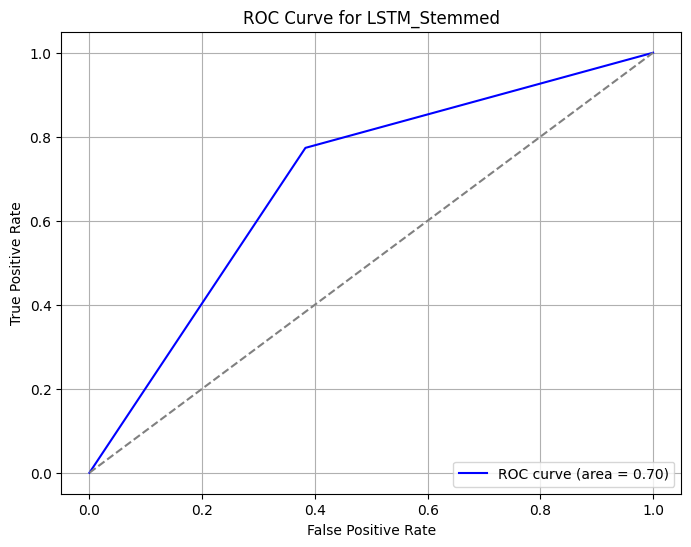

In [97]:
from sklearn.metrics import roc_curve

def plot_roc_curve(y_true, y_pred, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f"ROC curve (area = {roc_auc_score(y_true, y_pred):.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

plot_roc_curve(y_test_true, y_test_pred, title=f"ROC Curve for {name}")
